In [1]:
# Yomitoku Clientの使用例
# このノートブックでは、Yomitoku Clientを使用してSageMaker Yomitokuの出力を
# 様々な形式（CSV、Markdown、HTML、JSON）に変換する方法を示します

# 必要なライブラリのインポート
from yomitoku_client import YomitokuClient  # メインのクライアントクラス
from yomitoku_client.parsers.sagemaker_parser import SageMakerParser  # SageMakerの出力をパースするクラス
from yomitoku_client.samples import load_pdf_sample, load_image_sample, get_image_sample_path # サンプルデータ（PDFと画像）
from pprint import pprint
import pandas as pd

In [2]:
# ====================
# Parserの詳細説明
# ====================

# SageMakerParser とは？
# - AWS SageMaker の Yomitoku サービスから返される生のJSON出力を
#   Python の型安全な Pydantic モデルに変換するクラスです
# 
# 主な機能：
# 1. 生のJSONデータを構造化されたPythonオブジェクトに変換
# 2. データの検証とバリデーション
# 3. 型安全性の確保（IDEの補完機能が使える）
# 4. 各種フォーマットへの変換を容易にする

parser = SageMakerParser()
client = YomitokuClient()

print("✅ SageMakerParser と YomitokuClient を初期化完了")

✅ SageMakerParser と YomitokuClient を初期化完了


In [4]:
#サンプル画像をダウンロード
import requests

def download_file(url, filename):
    response = requests.get(url, stream=True)
    if response.status_code == 200:
        with open(filename, 'wb') as f:
            for chunk in response.iter_content(1024):
                f.write(chunk)
        file_type = "Image" if filename.endswith(".png") else "PDF"
        print(f"{file_type} saved as {filename}")
    else:
        print(f"Failed to download file. Status code: {response.status_code}")

download_file(
    "https://mlism-marketplace-documents.s3.ap-northeast-1.amazonaws.com/samples/gallery1.jpg",
    "../src/yomitoku_client/samples/image_sample.png"
)
download_file(
    "https://www.soumu.go.jp/main_content/000975178.pdf",
    "../src/yomitoku_client/samples/pdf_sample.pdf"
)


# 画像サンプルデータを読み込み（これはYomitoku APIの出力形式のJSONデータ）
image_sample_data = load_image_sample()

# parse_dict: SageMaker Yomitokuの辞書形式の出力をPydanticモデルに変換
img_data = parser.parse_dict(image_sample_data)

print("\n=== パース後のimg_data ===")
print(f"データ型: {type(img_data)}")
print(f"ドキュメント数: {len(img_data)}")
## 画像サンプルの処理
### 画像から抽出されたテキストとレイアウト情報を様々な形式に変換

Image saved as ../src/yomitoku_client/samples/image_sample.png
PDF saved as ../src/yomitoku_client/samples/pdf_sample.pdf

=== パース後のimg_data ===
データ型: <class 'list'>
ドキュメント数: 1


In [5]:
pdf_sample_data = load_pdf_sample()
# PDFの場合も同様にSageMaker Yomitokuの出力をPydanticモデルに変換
pdf_data = parser.parse_dict(pdf_sample_data)

## データエクスポート機能
### 様々な形式への変換とファイル保存

このセクションでは、OCR処理済みのデータを実用的な各種フォーマットに変換し、ファイルとして保存する方法を示します。

**対応フォーマット：**
- **CSV**: Excel等の表計算ソフトで開ける形式。データ分析に最適
- **Markdown**: GitHubやドキュメント作成に便利な軽量マークアップ形式
- **HTML**: ブラウザで直接表示可能。レポートやプレゼンテーションに活用
- **JSON**: プログラムで処理しやすい構造化データ。API連携やデータベース保存に最適

すべてのエクスポートファイルは `exported_data/` ディレクトリに整理して保存されます。

In [6]:
# エクスポート用のディレクトリを作成
import os
export_dir = "exported_data"
if not os.path.exists(export_dir):
    os.makedirs(export_dir)
    print(f"📁 エクスポートディレクトリを作成: {export_dir}/")
else:
    print(f"📁 既存のエクスポートディレクトリを使用: {export_dir}/")

📁 エクスポートディレクトリを作成: exported_data/


In [7]:
# データを各フォーマットに変換してエクスポート
import json

formats = ['csv', 'md', 'html', 'json']
format_names = {'csv': 'CSV', 'md': 'Markdown', 'html': 'HTML', 'json': 'JSON'}

print("=" * 50)
print("📁 データエクスポート（全フォーマット）")
print("=" * 50)

for fmt in formats:
    print(f"\n📊 {format_names[fmt]}形式:")
    
    # 画像データとPDFデータを変換して保存
    for data_type, data in [('image', img_data), ('pdf', pdf_data)]:
        converted = client.convert_to_format(data, fmt)
        file_path = os.path.join(export_dir, f"{data_type}_data.{fmt}")
        
        # JSON形式は整形して保存
        if fmt == 'json':
            if data_type == 'image':
                json_obj = json.loads(converted.replace('--- Document 1 ---\n', ''))
                with open(file_path, 'w', encoding='utf-8') as f:
                    json.dump(json_obj, f, ensure_ascii=False, indent=2)
            else:  # PDFの複数ドキュメント処理
                json_docs = []
                for doc in converted.split('--- Document '):
                    if doc.strip() and '---' in doc:
                        doc_content = doc.split('---\n', 1)[1]
                        if doc_content.strip():
                            try:
                                json_docs.append(json.loads(doc_content))
                            except:
                                pass
                with open(file_path, 'w', encoding='utf-8') as f:
                    json.dump(json_docs, f, ensure_ascii=False, indent=2)
        else:
            with open(file_path, 'w', encoding='utf-8') as f:
                f.write(converted)
        
        size = os.path.getsize(file_path)
        print(f"  ✓ {data_type}_data.{fmt} ({size:,} bytes)")

print(f"\n✅ 全ファイルを {export_dir}/ に保存完了")

📁 データエクスポート（全フォーマット）

📊 CSV形式:
  ✓ image_data.csv (8,005 bytes)
  ✓ pdf_data.csv (39,466 bytes)

📊 Markdown形式:
  ✓ image_data.md (8,408 bytes)
  ✓ pdf_data.md (40,659 bytes)

📊 HTML形式:
  ✓ image_data.html (8,764 bytes)
  ✓ pdf_data.html (43,097 bytes)

📊 JSON形式:
  ✓ image_data.json (107,556 bytes)
  ✓ pdf_data.json (664,804 bytes)

✅ 全ファイルを exported_data/ に保存完了


## 可視化
### OCR結果の視覚的な確認と分析

このセクションでは、OCRで検出されたテキスト、図表、テーブルなどの要素を画像上に可視化する機能を紹介します。

**可視化機能の特徴：**
- **レイアウト構造の理解**: 文書の階層構造や配置を視覚的に確認
- **信頼度スコアの可視化**: OCR認識の信頼度を色分けして表示
- **要素関係の分析**: テキスト、図表、テーブル間の関係性を可視化

これらの可視化機能により、OCR結果の品質確認や文書構造の理解が容易になります。

In [8]:
from yomitoku_client.visualizers import (
    ChartVisualizer,
    TableVisualizer,
    DocumentVisualizer
)

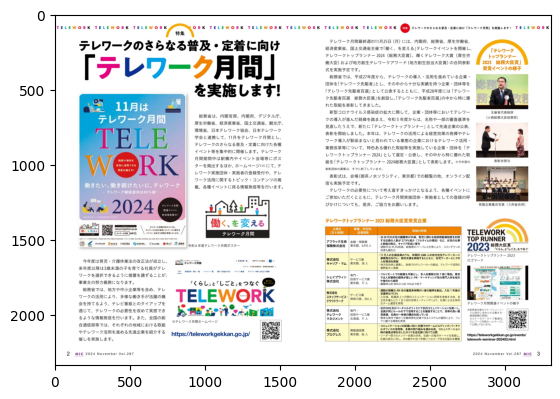

In [9]:
# サンプル画像を表示
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import numpy as np

image_path = get_image_sample_path()
# 画像を読み込んで表示
img = Image.open(image_path)
plt.imshow(img)

### レイアウト

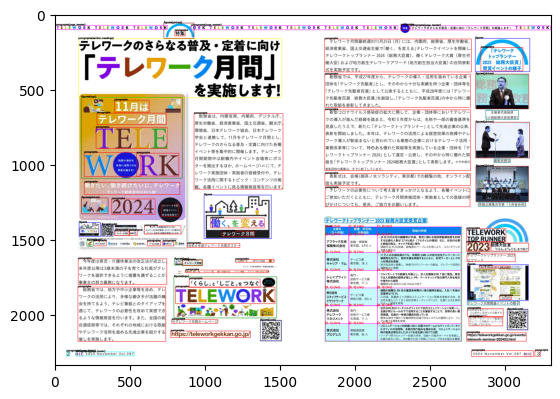

In [10]:
# DocumentVisualizerを使用してレイアウトの詳細を可視化
# visualize: 画像とパースされたデータを受け取り、バウンディングボックスを描画
# type='layout_detail': レイアウトの詳細（テキスト、図、表の位置）を表示

doc_viz = DocumentVisualizer()
result_img = doc_viz.visualize((str(image_path), img_data), type='layout_detail')
# result_img: バウンディングボックスが描画された画像
plt.imshow(result_img)
plt.show()

### 信頼度スコア

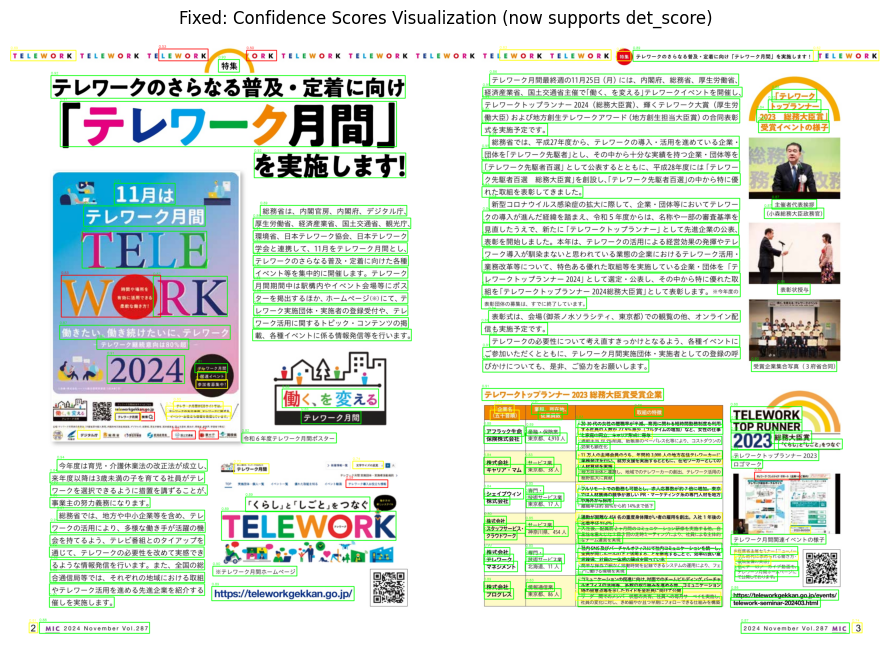

det_scoreを使用して信頼度を可視化


In [11]:
confidence_img_fixed = doc_viz.visualize_confidence_scores(
    cv2.imread(str(image_path)),
    img_data[0] if isinstance(img_data, list) else img_data,
    show_ocr_confidence=True,
    show_detection_confidence=False
)

# 元画像と比較して変更があったかチェック
original_img = cv2.imread(str(image_path))
if not np.array_equal(confidence_img_fixed, original_img):
    plt.figure(figsize=(12, 8))
    plt.imshow(cv2.cvtColor(confidence_img_fixed, cv2.COLOR_BGR2RGB))
    plt.title("Fixed: Confidence Scores Visualization (now supports det_score)")
    plt.axis('off')
    plt.show()
    print("det_scoreを使用して信頼度を可視化")
else:
    print("⚠️ 可視化が適用されませんでした")

### 要素関係

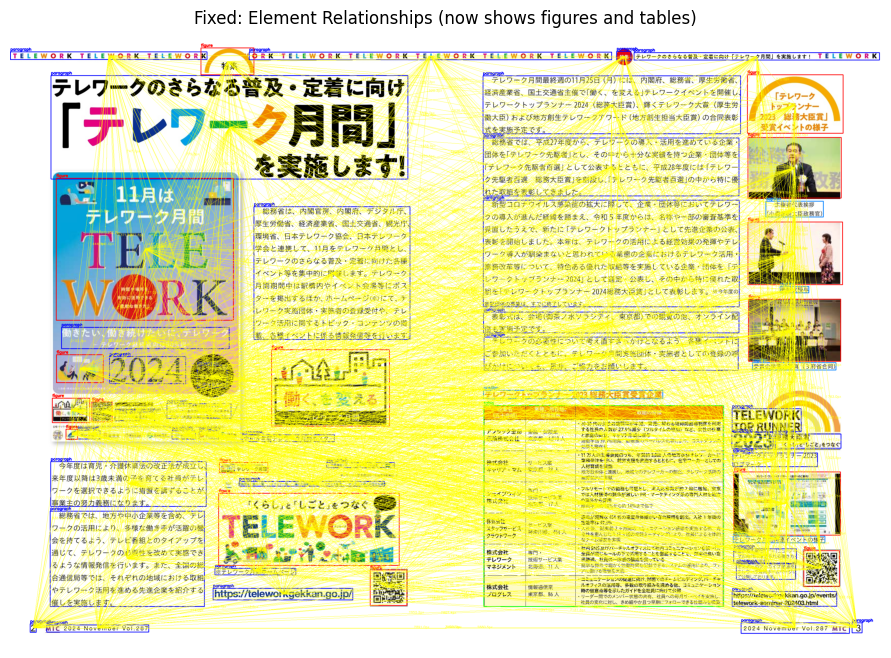

In [12]:
relationship_img_fixed = doc_viz.visualize_element_relationships(
    cv2.imread(str(image_path)),
    img_data[0] if isinstance(img_data, list) else img_data,
    show_overlaps=True,
    show_distances=True  # 距離表示
)

plt.figure(figsize=(12, 8))
plt.imshow(cv2.cvtColor(relationship_img_fixed, cv2.COLOR_BGR2RGB))
plt.title("Fixed: Element Relationships (now shows figures and tables)")
plt.axis('off')
plt.show()

## テーブルデータの確認と変換
### TableVisualizerを使用してテーブルデータを処理

In [13]:
# テーブルデータの確認と変換
from yomitoku_client.visualizers import TableVisualizer

table_viz = TableVisualizer()

# 画像データからテーブルを探す
if hasattr(img_data[0], 'tables') and img_data[0].tables:
    print(f"✅ 画像サンプルから {len(img_data[0].tables)} 個のテーブルを発見")
    
    # 最初のテーブルを取得
    table_obj = img_data[0].tables[0]
    print(f"   サイズ: {table_obj.n_row} 行 x {table_obj.n_col} 列")
    
    # テーブルデータをDataFrameに変換
    max_row = max(cell.row for cell in table_obj.cells)
    max_col = max(cell.col for cell in table_obj.cells)
    
    table_array = [[""] * max_col for _ in range(max_row)]
    for cell in table_obj.cells:
        table_array[cell.row - 1][cell.col - 1] = cell.contents
    
    df = pd.DataFrame(table_array, columns=[f"Column_{i+1}" for i in range(max_col)])
    
    # DataFrameの最初の5行を表示
    print("\n📊 テーブルデータのプレビュー:")
    print(df.head())
    
else:
    print("⚠️ 画像サンプルにテーブルが見つかりません")
    df = None

✅ 画像サンプルから 1 個のテーブルを発見
   サイズ: 7 行 x 3 列

📊 テーブルデータのプレビュー:
                   Column_1               Column_2  \
0               企業名\n(五十音順)          業種、所在地、\n従業員数   
1           アフラック生命\n保険株式会社     金融・保険業\n東京都、4,910人   
2             株式会社\nキャリア·マム         サービス業\n東京都、38人   
3             シェイプウィン\n株式会社  専門·\n技術サービス業\n東京都、17人   
4  株式会社\nスタッフサービス·\nクラウドワーク       サービス業\n神奈川県、454人   

                                            Column_3  
0                                              取組の特徴  
1  ·20-30 代の女性の離職率が半減、育児に関わる短時間勤務制度を利用\nする社員の人数が ...  
2  ·11万人の主婦会員のうち、年間約3,000 人の地方在住テレワーカーに\n業務発注を行い、...  
3  ·フルリモートでの勤務も可能とし、求人応募数が約7倍に増加。東京\nでは人材獲得の競争が激し...  
4  ·通勤が困難な 454 名の重度身体障がい者の雇用を創出。入社 1年後の\n定着率は 97....  


### CSV形式の生成と保存
#### Excel等で開けるCSV形式にテーブルを変換

In [14]:
# CSV形式で保存（Excel等で開ける）
if df is not None:
    csv_output = df.to_csv(index=False)
    
    # ファイルに保存
    csv_path = 'table_output.csv'
    with open(csv_path, 'w', encoding='utf-8') as f:
        f.write(csv_output)
    
    print(f"📄 CSV形式で保存: {csv_path} ({os.path.getsize(csv_path):,} bytes)")
    
    # 内容の一部を表示
    print("\nCSVファイルの最初の3行:")
    print('\n'.join(csv_output.split('\n')[:4]))

📄 CSV形式で保存: table_output.csv (2,747 bytes)

CSVファイルの最初の3行:
Column_1,Column_2,Column_3
"企業名
(五十音順)","業種、所在地、
従業員数",取組の特徴


### テキスト形式の生成と保存
#### プレーンテキストとして読みやすい形式で出力

In [15]:
# テキスト形式で保存
if df is not None:
    text_output = table_viz.visualize(df, format='text', index=False)
    
    # ファイルに保存
    text_path = 'table_output.txt'
    with open(text_path, 'w', encoding='utf-8') as f:
        f.write(text_output)
    
    print(f"📝 テキスト形式で保存: {text_path} ({os.path.getsize(text_path):,} bytes)")
    
    # 内容を表示
    print("\nテキスト形式の出力:")
    print(text_output)

📝 テキスト形式で保存: table_output.txt (3,376 bytes)

テキスト形式の出力:
                Column_1              Column_2                                                                                                                                                            Column_3
             企業名\n(五十音順)         業種、所在地、\n従業員数                                                                                                                                                               取組の特徴
         アフラック生命\n保険株式会社    金融・保険業\n東京都、4,910人                             ·20-30 代の女性の離職率が半減、育児に関わる短時間勤務制度を利用\nする社員の人数が 27.9%減少(フルタイムの増加)など、女性の仕事\nと家庭の両立、キャリア形成に寄与\n·通勤手当 39.3%削減、紙帳票のペーパレス化等により、コストダウンの\n効果も顕在化
           株式会社\nキャリア·マム        サービス業\n東京都、38人                                         ·11万人の主婦会員のうち、年間約3,000 人の地方在住テレワーカーに\n業務発注を行い、就労支援を実施するとともに、在宅ワーカーとしての\n人材育成を実施\n·地方自治体と連携し、地域でのテレワーカーの創出、テレワーク活用の\n裾野拡大に貢献
           シェイプウィン\n株式会社 専門·\n技術サービス業\n東京都、17人                                                      

### HTML形式の生成と保存
#### ブラウザで表示可能なスタイル付きHTMLテーブル

In [16]:
# HTML形式で保存（ブラウザで表示可能）
if df is not None:
    html_output = table_viz.visualize(df, format='html', index=False)
    
    # スタイル付きHTMLドキュメントとして生成
    html_doc = f"""<!DOCTYPE html>
<html>
<head>
    <meta charset="utf-8">
    <title>テーブルデータ</title>
    <style>
        body {{ 
            font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif; 
            margin: 40px; 
            background-color: #f5f5f5;
        }}
        h1 {{ 
            color: #333; 
            border-bottom: 2px solid #4CAF50;
            padding-bottom: 10px;
        }}
        table {{ 
            border-collapse: collapse; 
            width: 100%; 
            margin-top: 20px; 
            background: white;
            box-shadow: 0 2px 4px rgba(0,0,0,0.1);
        }}
        th, td {{ 
            border: 1px solid #ddd; 
            padding: 12px; 
            text-align: left; 
        }}
        th {{ 
            background-color: #4CAF50; 
            color: white; 
            font-weight: bold;
        }}
        tr:nth-child(even) {{ 
            background-color: #f9f9f9; 
        }}
        tr:hover {{
            background-color: #f5f5f5;
        }}
    </style>
</head>
<body>
    <h1>OCRで抽出されたテーブルデータ</h1>
    {html_output}
</body>
</html>"""
    
    # ファイルに保存
    html_path = 'table_output.html'
    with open(html_path, 'w', encoding='utf-8') as f:
        f.write(html_doc)
    
    print(f"🌐 HTML形式で保存: {html_path} ({os.path.getsize(html_path):,} bytes)")
    print("   → ブラウザで開いてご確認ください")

🌐 HTML形式で保存: table_output.html (4,567 bytes)
   → ブラウザで開いてご確認ください


### JSON形式の生成と保存
#### 構造化されたJSONデータとして出力（APIやデータ交換に便利）

In [17]:
# JSON形式で保存（API連携用）
if df is not None:
    import json
    
    # index=False を使用すると、リスト形式のJSONが生成される
    json_output = table_viz.visualize(df, format='json', index=False)
    
    # ファイルに保存
    json_path = 'table_output.json'
    with open(json_path, 'w', encoding='utf-8') as f:
        json.dump(json_output, f, ensure_ascii=False, indent=2)
    
    print(f"🔧 JSON形式で保存: {json_path} ({os.path.getsize(json_path):,} bytes)")
    
    # 構造の一部を表示
    print("\nJSON構造のプレビュー:")
    # json_outputがリストの場合は最初の2つの要素を表示
    if isinstance(json_output, list):
        preview = json_output[:2] if len(json_output) > 2 else json_output
    elif isinstance(json_output, dict):
        # 辞書の場合、'data'キーがあればそれを表示、なければ最初の2つのキー
        if 'data' in json_output:
            preview = {"data": json_output['data'][:2] if len(json_output['data']) > 2 else json_output['data']}
        else:
            preview = {k: json_output[k] for k in list(json_output.keys())[:2]}
    else:
        preview = json_output
    print(json.dumps(preview, ensure_ascii=False, indent=2))

🔧 JSON形式で保存: table_output.json (3,178 bytes)

JSON構造のプレビュー:
[
  {
    "Column_1": "企業名\n(五十音順)",
    "Column_2": "業種、所在地、\n従業員数",
    "Column_3": "取組の特徴"
  },
  {
    "Column_1": "アフラック生命\n保険株式会社",
    "Column_2": "金融・保険業\n東京都、4,910人",
    "Column_3": "·20-30 代の女性の離職率が半減、育児に関わる短時間勤務制度を利用\nする社員の人数が 27.9%減少(フルタイムの増加)など、女性の仕事\nと家庭の両立、キャリア形成に寄与\n·通勤手当 39.3%削減、紙帳票のペーパレス化等により、コストダウンの\n効果も顕在化"
  }
]


## 機能デモ: SearchablePDFGenerator
### OCR結果から検索可能なPDFを生成

In [18]:
# SearchablePDFGeneratorをインポート
# 画像とOCR結果から検索可能なPDFを生成するクラス
from yomitoku_client.pdf_generator import SearchablePDFGenerator

# PDFジェネレーターのインスタンスを作成
pdf_generator = SearchablePDFGenerator()

print("✅ SearchablePDFGeneratorを初期化しました")

✅ SearchablePDFGeneratorを初期化しました


In [19]:
# 画像サンプルから検索可能なPDFを生成
import cv2
import os
from yomitoku_client.pdf_generator import SearchablePDFGenerator
from yomitoku_client.samples import get_image_sample_path

# 画像ファイルを読み込み（パッケージ内のサンプル画像を使用）
image_path = get_image_sample_path()
image_np = cv2.imread(str(image_path))

pdf_generator = SearchablePDFGenerator() 

# 検索可能なPDFを生成
output_path = "searchable_output.pdf"
pdf_generator.create_searchable_pdf(
    images=[image_np],
    ocr_results=[img_data[0]],
    output_path=output_path
)

print(f"✅ 検索可能なPDFを生成: {output_path}")

✅ 検索可能なPDFを生成: searchable_output.pdf


## 機能デモ: PDFレンダラー
### OCR結果をPDF形式でレンダリング

In [20]:
from yomitoku_client.renderers.pdf_renderer import PDFRenderer
from yomitoku_client.samples import get_image_sample_path
import cv2
import os

# PDFレンダラーを初期化（自動的に内置フォントを使用）
pdf_renderer = PDFRenderer()  # フォントパス不要

# 画像とデータを読み込み（パッケージ内のサンプル画像を使用）
image_path = get_image_sample_path()
image_np = cv2.imread(str(image_path))
output_path_img = "image_sample_rendered.pdf"

# PDFを生成
pdf_renderer.save(
    img_data[0] if isinstance(img_data, list) else img_data,
    output_path_img,
    img=image_np
)

print(f"✅ PDFを生成: {output_path_img}")

✅ PDFを生成: image_sample_rendered.pdf
